In [1]:
import numpy as np
import os
from sklearn import ensemble, model_selection
import torch
from target_defs import archetype_sequences, archetype_predictions, archetype_plaintext


class EnsembleRFModel(object):

    def __init__(self, n_models=3, constructor=ensemble.RandomForestRegressor, model_params={}, symmetrize=False):
        self.n_models = n_models
        self.model_params = model_params
        self.symmetrize = symmetrize
        self.models = [constructor(**self.model_params) for _ in range(self.n_models)]

    def fit(self, x, y):
        cv = model_selection.KFold(n_splits=self.n_models, shuffle=True, random_state=0)
        for i, (fold_train_idx, fold_val_idx) in enumerate(cv.split(x)):
            if self.symmetrize:
                this_x = x[fold_train_idx]
                this_x = np.vstack([this_x, [it[::-1] for it in this_x]])
                this_y = y[fold_train_idx]
                this_y = np.hstack([this_y, this_y])
                _ = self.models[i].fit(this_x, this_y)
            else:
                _ = self.models[i].fit(x[fold_train_idx], y[fold_train_idx])
        return self

    def predict(self, x, return_std=False):
        
        if self.symmetrize:
            all_yf = np.vstack([it.predict(x).reshape(1, -1) for it in self.models])
            all_yr = np.vstack([it.predict([it[::-1] for it in x]).reshape(1, -1) for it in self.models])
            all_y = 0.5 * (all_yf + all_yr)
        else:
            all_y = np.vstack([it.predict(x).reshape(1, -1) for it in self.models])

        if return_std:
            return np.mean(all_y, axis=0), np.std(all_y, axis=0)
        else:
            return np.mean(all_y, axis=0)
        
        
# generate all sequences by composition
n = 20
all_seq_by_frac = {k: set() for k in range(n+1)}
limit = 2**n
for i in range(limit):
    sequence = bin(i)[2:].zfill(n)
    mirror_sequence = sequence[::-1]
    if sequence <= mirror_sequence:
        all_seq_by_frac[sequence.count('1')].add(sequence)

# create a master list of all possible sequences
all_sequences = []
for k, v in all_seq_by_frac.items():
    all_sequences += v
print(f'generated {len(all_sequences)} sequences')        

possible_sequences = np.array(list(all_seq_by_frac[8]))

# load the model ensemble
drive_prefix = '/Users/wfr5091/Google Drive/Shared drives/Polymers-Data'

model_ensemble = []
model_path = os.path.join(drive_prefix, 'models', 'gru-opt-cv10-sym')
for i in range(10):
    model = torch.jit.load(os.path.join(model_path, f'fold-{i:02d}-scripted.pt'), map_location='cpu')
    model.eval()
    model_ensemble.append(model)
    
# archetype_predictions = {'liquid': np.array([18.177, 2.932]),
#                      'membrane': np.array([1.132, 8.499]),
#                      'spherical micelle': np.array([2.901, -4.351]),
#                      'string': np.array([-4.079, 6.662]),
#                      'vesicle': np.array([6.498, 8.414]),
#                      'wormlike micelle': np.array([-3.771, 0.172]),
#                      }    

generated 524800 sequences


In [2]:
import model_utils
archetype_sequences = {'wormlike_v3': 'ABBBAABBAAAABBBAAAAA',
                     }
preds = model_utils.run_sequences(list(archetype_sequences.values()), model_ensemble).split('\n')
archetype_predictions = {}
for i, (k, v) in enumerate(archetype_sequences.items()):
    z_pred_str = f"np.array([{preds[i].split(':')[1]}])"
    archetype_predictions[k] = z_pred_str
print('\n'.join([it.replace("'np", "np") for it in str(archetype_predictions).split("', ")]))

{'wormlike_v3': np.array([ -4.179, 0.534])'}


In [3]:
from sklearn import model_selection
import itertools
import tqdm.notebook
import numpy as np


def swap_monomers(seq):
    seq = seq.replace('A', 'C')
    seq = seq.replace('B', 'A')
    seq = seq.replace('C', 'B')
    return seq


def make_base(degree, verbose=False):
    # construct unique numbers of A/B monomers
    base = []
    for i in range(degree+1):
        for j in range(i):
            seq = ''.join(['A' for _ in range(i-j)] + ['B' for _ in range(j)])
            base += [''.join(x) for x in itertools.permutations(seq)]
            base += [''.join(x) for x in itertools.permutations(swap_monomers(seq))]
    base = sorted(set(base))
    pruned_base = []
    for b in base:
        if b not in pruned_base and b[::-1] not in pruned_base:
            pruned_base.append(b)
    base = pruned_base
    if verbose:
        print(f'Finding {len(base)} patterns:', base)

    return base


def featurize(chain_sequences, base, symmetric=False, verbose=False):
    x = np.zeros([len(chain_sequences), len(base)])
    pbar = tqdm.notebook.tqdm(enumerate(chain_sequences),
                              total=len(chain_sequences),
                              disable=(not verbose))
    for i, chain in pbar:
        if 'A' in str(chain):
            seq = chain
        else:
            seq = ''.join(['A' if x == 0 else 'B' for x in chain])
        x[i] = np.array([seq.count(b) for b in base])
        if symmetric:
            x[i] += np.array([seq[::-1].count(b) for b in base])

    return x


base = make_base(degree=4)
possible_tokens = featurize(possible_sequences, base, symmetric=True)

In [4]:
import message_utils, model_utils

batch_prompt = "Here\n<result>\nNote"

AB = {'A': 0, 'B': 1}
all_arrs = np.array([[int(x) for x in s] for s in possible_sequences])

In [19]:
import importlib
importlib.reload(message_utils)

<module 'message_utils' from '/Users/wfr5091/Code/macro-llm/message_utils.py'>

In [38]:
import json
import time
import tqdm

import target_defs
import importlib
importlib.reload(target_defs)
from target_defs import archetype_predictions

arch_morphs = [k for k in archetype_predictions.keys() if 'arch_' in k]
# arch_morphs = ['string_v2']
print(arch_morphs)
for morph in arch_morphs:
    
    # morph = "string"
    target = archetype_predictions[morph]
    
    rollouts = []
    
    n_batch = 5
    n_init = 5
    n_total = 10
    xi = 0
    
    use_tokens = False
    symmetrize = False
    use_seed = False
    
    params = {'n_batch': n_batch,
            'n_init': n_init,
            'xi': xi,
            'use_tokens': use_tokens,
            'symmetrize': symmetrize,
            'target': target.tolist(),
            'morph': morph,
            'use_seed': use_seed}
    
    start_time = int(time.time())
    for ridx in range(5):
        fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
        
        # rf = ensemble.RandomForestRegressor(random_state=0)
        rf = EnsembleRFModel(model_params={'random_state': ridx, 'n_estimators': 24, 'max_depth': 6}, symmetrize=(symmetrize and not use_tokens))
        
        rng = np.random.RandomState(ridx)
        init_idx = rng.choice(np.arange(len(possible_sequences)), n_init, replace=False)
        init_bitstr = [possible_sequences[it] for it in init_idx]
        if use_seed:
            init_bitstr[0] = archetype_sequences[morph]
        init_sequences = [it.replace('0', 'A').replace('1', 'B') for it in init_bitstr]
        
        if use_tokens:
            x_so_far = featurize(init_sequences, base, symmetric=True)
        else:
            x_so_far = np.array([[int(AB[x]) for x in s] for s in init_sequences])
        
        out = model_utils.evaluate_sequences(init_sequences, target, model_ensemble)
        fake_payload.append(message_utils.build_user_message(batch_prompt, out))
        y_so_far = np.array([float(it.split(':')[1]) for it in out.split('\n')])
        
        _ = rf.fit(x_so_far, y_so_far)
        
        is_avail = np.ones(len(possible_sequences)).astype(bool)
        is_avail[init_idx] = False
        
        for _ in tqdm.tqdm(range(n_total-n_init//n_batch)):
            
            if use_tokens:
                mu, sigma = rf.predict(possible_tokens, return_std=True)
            else:
                mu, sigma = rf.predict(all_arrs, return_std=True)
    
            o = np.hstack([np.argsort(mu - xi * sigma)])
            next_sequences = []
            k = 0
            while len(next_sequences) < n_batch:
                if is_avail[o[k]]:
                    next_bitstr = possible_sequences[o[k]]
                    seq = next_bitstr.replace('0', 'A').replace('1', 'B')
                    next_sequences.append(seq)
                    is_avail[o[k]] = False
                k += 1
            
            if use_tokens:
                next_x = featurize(next_sequences, base, symmetric=True)
            else:
                next_x = np.array([[int(AB[x]) for x in s] for s in next_sequences])
            x_so_far = np.vstack([x_so_far, next_x])
            
            out = model_utils.evaluate_sequences(next_sequences, target, model_ensemble)
            fake_payload.append(message_utils.build_user_message(batch_prompt, out))
            y_so_far = np.hstack([y_so_far, np.array([float(it.split(':')[1]) for it in out.split('\n')])])
            
            _ = rf.fit(x_so_far, y_so_far)
        
        buffer = {'params': params, 'messages': fake_payload}
        suffix = str(ridx)
        logfile = f'logs/active-learning-{start_time}{suffix}.json'
        with open(logfile, 'w') as fid:
            json.dump(buffer, fid)
        
        rollouts.append(fake_payload)
            
        # fig, ax = message_utils.plot_results_from_messages(fake_payload)    


['string_v2']


100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


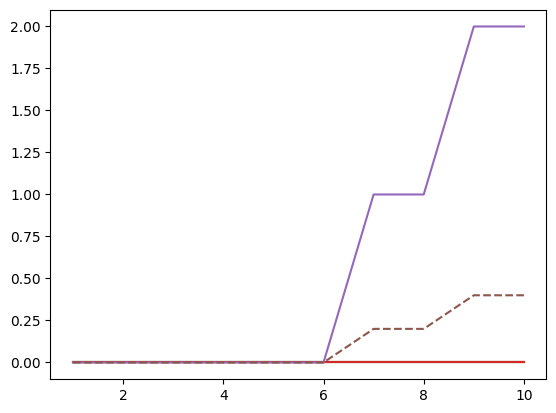

In [39]:
import matplotlib.pyplot as plt

results = []
n = 0
for fake_payload in rollouts:    
    iteration_scores = message_utils.extract_results_from_messages(fake_payload)
    scs = message_utils.sorted_cumulative_scores(iteration_scores)
    kbd = message_utils.k_below_d(scs, 0.67*2)
    results.append(kbd)
    if len(scs) > n:
        n = len(scs)

results_arr = np.zeros((len(rollouts), n)) * np.nan
for i, r in enumerate(results):
    results_arr[i, :len(r)] = r

offs = n_init / n_batch
for r in results_arr:
    plt.plot(np.arange(results_arr.shape[1])+offs, r)

plt.plot(np.arange(results_arr.shape[1])+offs, np.nanmean(results_arr, axis=0), '--')

In [ ]:
fig, ax = message_utils.plot_results_from_messages(fake_payload) 

In [5]:
# do the same for random 
n = 20
all_seq_by_frac = {k: set() for k in range(n+1)}
limit = 2**n
for i in range(limit):
    sequence = bin(i)[2:].zfill(n)
    mirror_sequence = sequence[::-1]
    if sequence <= mirror_sequence:
        all_seq_by_frac[sequence.count('1')].add(sequence)

# create a master list of all possible sequences
all_sequences = []
for k, v in all_seq_by_frac.items():
    all_sequences += v
print(f'generated {len(all_sequences)} sequences')
possible_sequences = all_seq_by_frac[8]
print(f'choosing from {len(possible_sequences)} sequences')

generated 524800 sequences
choosing from 63090 sequences


In [61]:
import model_utils, message_utils

# arch_morphs = [k for k in archetype_predictions.keys() if 'arch_' in k]
# arch_morphs = ['string_v2']
# print(arch_morphs)
# for morph in arch_morphs:
  
n_batch = 5
n_iter = 10
  
arch_morphs = [k for k in archetype_predictions.keys() if '_' not in k]
for morph in arch_morphs:

    target = archetype_predictions[morph]

    params = {'n_batch': n_batch,
            'target': target.tolist(),
            'morph': morph,
              }

    start_time = time.time()
    for ridx in range(1):
        
        fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
    
        these_bitstr = np.random.choice(list(possible_sequences), n_batch*n_iter, replace=False)
        these_sequences = [it.replace('0', 'A').replace('1', 'B') for it in these_bitstr]
        
        seq_by_iter = np.array_split(these_sequences, n_iter)
        
        for i in range(n_iter):
            out = model_utils.evaluate_sequences(seq_by_iter[i], target, model_ensemble)
            fake_payload.append(message_utils.build_user_message(batch_prompt, out))
        
        buffer = {'params': params, 'messages': fake_payload}
        suffix = str(ridx)
        logfile = f'logs/random-{start_time}{suffix}.json'
        with open(logfile, 'w') as fid:
            json.dump(buffer, fid)

# evolutionary programming

In [6]:
archetype_predictions.keys()

dict_keys(['wormlike_v3'])

In [286]:
arch_morphs = [k for k in archetype_predictions.keys() if '_' not in k]
print(arch_morphs)

['liquid', 'membrane', 'spherical micelle', 'string', 'vesicle', 'wormlike micelle']


In [10]:
possible_sequences = list(possible_sequences)

In [193]:
from deap import algorithms, base, creator, tools
import json
import numpy as np
import random
from target_defs import archetype_predictions, archetype_sequences
import time

use_feasibility = False

arch_morphs = [k for k in archetype_predictions.keys() if '_' not in k]
# arch_morphs.remove("spherical micelle")  # already done
# arch_morphs = ["spherical micelle"]
for morph in arch_morphs:
# morph = "wormlike micelle"
# print(morph)
    target = archetype_predictions[morph]
    
    start_time = int(time.time())
    for ridx in range(5):
        
        individuals = [] 
        
        delta = 0.0
        
        def evalSeq(individual):
            sequence = ''.join([str(it) for it in individual]).replace('0', 'A').replace('1', 'B')
            out = model_utils.evaluate_sequences([sequence], target, model_ensemble)
            # fake_payload.append(message_utils.build_user_message(batch_prompt, out))
            score = [float(it.split(':')[1]) for it in out.split('\n')][0]
            if not use_feasibility:  # only add this to score if not using feasibility
                score += delta + np.abs(np.sum(individual) - 8.0)
            # if np.sum(individual) == 8:  # only keep track of feasible individuals
            individuals.append((individual, score, feasible(individual)))
            return score,

        def feasible(individual):
            """Feasibility function for the individual. Returns True if feasible False
            otherwise."""
            if np.sum(individual) == 8:
                return True
            return False

        def distance(individual):
            """A distance function to the feasibility region."""
            return (np.sum(individual) - 8.0)**2
        
        n_init = 5
        n_batch = 5
        use_seed = True
        
        fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
        rng = np.random.RandomState(ridx)
        init_idx = rng.choice(np.arange(len(possible_sequences)), n_init, replace=False)
        init_bitstr = [possible_sequences[it] for it in init_idx]
        if use_seed:
            init_bitstr[0] = archetype_sequences[morph].replace('A', '0').replace('B', '1')
        init_pop = [[int(x) for x in it] for it in init_bitstr]
        
        # rand_bitstr = [np.random.rand(20).round(0) for _ in range(n_batch - n_init)]
        # init_pop += [[int(x) for x in it] for it in rand_bitstr]
        
        random.seed(ridx)
        
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, 
            toolbox.attr_bool, 20)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", evalSeq)
        
        if use_feasibility:
            toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, delta, distance))
        
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        pop = toolbox.population(n=(n_batch - n_init))
        pop += [creator.Individual(p) for p in init_pop]
        if use_feasibility:
            not_feasible_init = [not feasible(it) for it in pop]
        else:
            not_feasible_init = 0
        
        hof = tools.HallOfFame(1000)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)
        
        cxpb, mutpb, ngen = 0.5, 0.2, 50
        pop, log = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                                       stats=stats, halloffame=hof, verbose=True)
        
        print(sum([it['nevals'] for it in log]))
        
        ind_by_gen = []
        k = 0
        for gen in log:
            n = gen['nevals']
            if k == 0:
                n -= np.sum(not_feasible_init)
            ind_by_gen.append(individuals[k:(k+n)])
            k += n
        
        params = {'n_batch': n_batch,
                  'n_init': n_init,
                  'target': target.tolist(),
                  'morph': morph,
                  'use_seed': use_seed,
                  'cxpb': cxpb,
                  'mutpb': mutpb,
                  'ngen': ngen,
                  'delta': delta}
        
        fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
        old_sequences = []
        for gen in ind_by_gen:
            sequences = [''.join([str(x) for x in it[0]]).replace('0', 'A').replace('1', 'B') for it in gen]
            sequences = [it for it in sequences if it not in old_sequences]
            if len(sequences) == 0:
                continue
            out = model_utils.evaluate_sequences(sequences, target, model_ensemble)
            fake_payload.append(message_utils.build_user_message(batch_prompt, out))
            old_sequences += sequences
            
        p_hash = message_utils.hash_dict(params)
        buffer = {'params': params, 'messages': fake_payload}
        suffix = str(ridx)
        logfile = (f'logs/deap-{p_hash}-{start_time}{suffix}.json')
        with open(logfile, 'w') as fid:
            json.dump(buffer, fid)

gen	nevals	avg   	std    	min	max   
0  	5     	11.802	6.32823	0  	17.433
1  	3     	12.3668	3.10231	6.958	16.265
2  	4     	9.2366 	2.03837	6.958	11.805
3  	3     	6.2794 	1.3572 	3.565	6.958 
4  	3     	6.4276 	1.07888	4.464	7.584 
5  	1     	6.0938 	0.959731	4.464	7.483 
6  	2     	5.241  	2.43975 	1.844	9.259 
7  	2     	4.282  	1.38729 	1.844	6.174 
8  	5     	3.5118 	1.3865  	1.844	5.092 
9  	4     	3.3426 	2.13275 	1.844	7.308 
10 	3     	4.4444 	3.40847 	1.844	10.265
11 	3     	2.9842 	2.2804  	1.844	7.545 
12 	5     	6.4998 	4.95393 	1.844	14.915
13 	4     	2.077  	0.844364	1.17 	3.683 
14 	2     	1.7092 	0.2696  	1.17 	1.844 
15 	1     	3.2558 	3.51056 	1.17 	10.251
16 	2     	1.17   	0       	1.17 	1.17  
17 	4     	1.7322 	1.1244  	1.17 	3.981 
18 	4     	1.7106 	1.0812  	1.17 	3.873 
19 	2     	1.17   	0       	1.17 	1.17  
20 	2     	1.0074 	0.3252  	0.357	1.17  
21 	4     	0.6822 	0.398287	0.357	1.17  
22 	4     	1.0772 	1.4404  	0.357	3.958 
23 	2     	0.357  	0       	

In [190]:
print(f'logs/deap-{p_hash}-{start_time}{suffix}.json')

logs/deap-aa065aac-17128652224.json


In [204]:
import json

start_time = int(time.time())
fake_payload = [{"role": "user", "content": [{"type": "text", "text": "N/A"}]}]
# old_sequences = []
for gen in ind_by_gen:
    sequences = [''.join([str(x) for x in it[0]]).replace('0', 'A').replace('1', 'B') for it in gen]
    # sequences = [it for it in sequences if it not in old_sequences]
    if len(sequences) == 0:
        continue
    out = model_utils.evaluate_sequences(sequences, target, model_ensemble)
    fake_payload.append(message_utils.build_user_message(batch_prompt, out))
    # old_sequences += sequences
buffer = {'params': params, 'messages': fake_payload}
suffix = str(ridx)
logfile = (f'logs/deap-{start_time}{suffix}.json')
with open(logfile, 'w') as fid:
    json.dump(buffer, fid)

(0.0, 50.0)

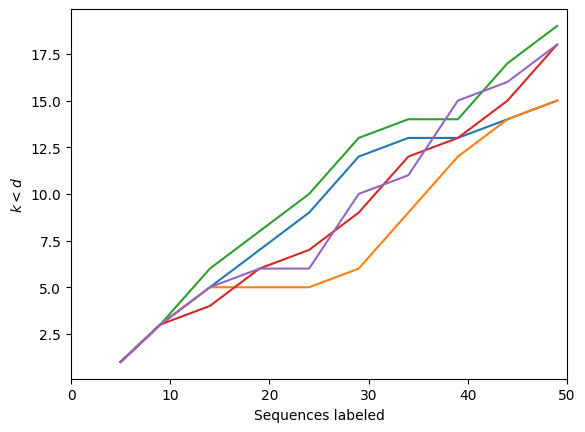

In [195]:
import matplotlib.pyplot as plt


def extract_results_from_messages(messages):
    old_sequences = []
    seq_init = [message_utils.extract_seq_from_init_message(messages[0])]
    user_messages = [it for it in messages if it['role'] == 'user']
    seq_lines = seq_init
    for it in user_messages[1:]:
        seq_lines += [message_utils.extract_seq_from_user_message(it)]
    iteration_scores = []
    for sl in seq_lines:
        seq = [it.split(':')[0] for it in sl.split('\n')[:-1]]
        is_new = [it not in old_sequences for it in seq]
        scores = [float(it.split(':')[1]) for it in sl.split('\n')[:-1]]
        scores = [it for i, it in enumerate(scores) if is_new[i]]
        old_sequences += seq
        iteration_scores.append(scores)
    return iteration_scores


fig, ax = plt.subplots()
for ridx in range(5):
    logfile = f"logs/claude-test-cac6ea50-1712867526{ridx}.json"
    with open(logfile, 'r') as fid:
        buffer = json.load(fid)
    fake_payload = buffer['messages']
    
    # iteration_scores = message_utils.extract_results_from_messages(fake_payload)
    iteration_scores = extract_results_from_messages(fake_payload)
    if len(iteration_scores[0]) == 0:
        iteration_scores = iteration_scores[1:]
    scs = message_utils.sorted_cumulative_scores(iteration_scores)
    kbd = message_utils.k_below_d(scs, 0.67*2)
    if len(scs) > n:
        n = len(scs)
        
    n_label = np.cumsum([len(it) for it in iteration_scores])    
    
    ax.plot(n_label, kbd)
    # if np.max(n_label) < 50:
    #     break
    
ax.set_xlabel('Sequences labeled')
ax.set_ylabel('$k < d$')
ax.set_xlim(0, 50)
# ax.set_ylim(0, 0.5)

In [36]:
fake_payload

[{'role': 'user', 'content': [{'type': 'text', 'text': 'N/A'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nABAAABBAAAABBABBBAAA: 0.000\nAABABAABBABAAAAAABBB: 6.405\nAAAABAABBBAABBAAABBA: 6.762\nAABAAAABABBAABABABAB: 8.470\nBAABAAAABABBAAABBAAB: 15.063\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nAABAABABBABAAAAAABBB: 6.522\nABAABABAAAABBABBBAAB: 10.078\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nAAAABAABBBBABBAAABAA: 10.059\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nAABAABBAAAABBAAAABBB: 2.241\nABAABBABABBAABBBBAAA: 10.155\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nABAAAABAAAABBABBBAAA: 3.574\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nABABABAAAAABBAABBAAA: 3.830\nAAAAABBAAAABBABBABAA: 8.739\nNote'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here\nABAABBBAAAABBBBBBA

In [37]:
len(fake_payload)

18

In [282]:
import importlib
importlib.reload(message_utils)

<module 'message_utils' from '/Users/wfr5091/Code/macro-llm/message_utils.py'>

(0.0, 20.0)

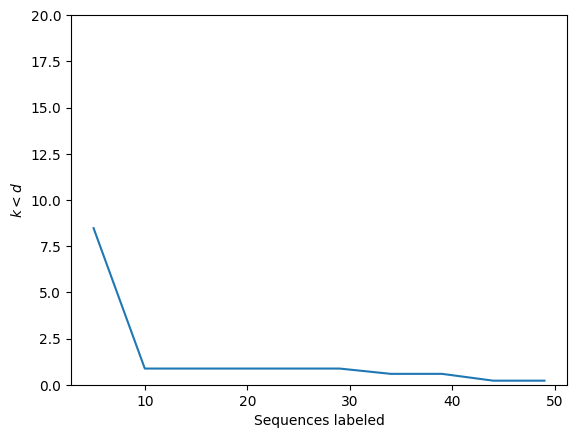

In [15]:
import matplotlib.pyplot as plt

def extract_results_from_messages(messages):
    old_sequences = []
    seq_init = [message_utils.extract_seq_from_init_message(messages[0])]
    user_messages = [it for it in messages if it['role'] == 'user']
    seq_lines = seq_init
    for it in user_messages[1:]:
        seq_lines += [message_utils.extract_seq_from_user_message(it)]
    iteration_scores = []
    for sl in seq_lines:
        seq = [it.split(':')[0] for it in sl.split('\n')[:-1]]
        is_new = [it not in old_sequences for it in seq]
        scores = [float(it.split(':')[1]) for it in sl.split('\n')[:-1]]
        scores = [it for i, it in enumerate(scores) if is_new[i]]
        old_sequences += seq
        iteration_scores.append(scores)
    return iteration_scores


top_k = 1

fig, ax = plt.subplots()
for ridx in range(1):
    logfile = f"logs/claude-test-1712329424{ridx}.json"
    with open(logfile, 'r') as fid:
        buffer = json.load(fid)
    fake_payload = buffer['messages']
    
    # iteration_scores = message_utils.extract_results_from_messages(fake_payload)
    iteration_scores = extract_results_from_messages(fake_payload)
    if len(iteration_scores[0]) == 0:
        iteration_scores = iteration_scores[1:]
    scs = message_utils.sorted_cumulative_scores(iteration_scores)
    
    kbd = []
    for it in scs:
        kbd.append(np.mean(it[1:(1+top_k)]))
    
    # kbd = message_utils.k_below_d(scs, 0.67*2)
    if len(scs) > n:
        n = len(scs)
        
    n_label = np.cumsum([len(it) for it in iteration_scores])    
    # ax.plot(kbd)
    ax.plot(n_label, kbd)
    
ax.set_xlabel('Sequences labeled')
ax.set_ylabel('$k < d$')
# ax.set_xlim(0, 50)
ax.set_ylim(0, 20)

In [284]:
iteration_scores

[[4.299, 5.62, 6.28, 9.744, 18.401],
 [6.048, 6.588, 6.79, 6.849, 8.624],
 [6.139, 6.416, 6.441, 16.438, 20.634]]

In [281]:
messages = fake_payload
user_messages = [it for it in messages if it['role'] == 'user']
print(user_messages[1]['content'][0]['text'].replace('\\n', '\n').split('\n'))
# message_utils.extract_seq_from_user_message(user_messages[1])

['Here are the sequences from the previous batch and their corresponding distances to the desired result:', 'AAAAABAABABABBAAABBB: 6.048', 'AAAAABAABABBABAAABBB: 6.588', 'AAAAABAABABBAABAAABB: 6.790', 'AAAAABAABABBABAAABAB: 6.849', 'AAAAABAABABBABAABABA: 8.624', 'Note that distances of less than 1.34 are considered good solutions.', 'Based on these results, please propose a new batch of five 20-character sequences that you think will yield smaller distances to the desired result, where each sequence meets the following criteria:', '1. Each sequence must be exactly 20 characters long.', "2. Each sequence must contain exactly 12 'A' characters and 8 'B' characters.", 'When proposing the new batch, consider the following guidelines:', '1. Sequences with distances less than 1.34 are considered good solutions, and you should propose sequences that are similar to these, with some variations to explore the nearby solution space.', '2. For sequences with distances between 1.34 and 2.68, propos

In [ ]:
def extract_results_from_messages(messages):
    old_sequences = []
    seq_init = [message_utils.extract_seq_from_init_message(messages[0])]
    user_messages = [it for it in messages if it['role'] == 'user']
    seq_lines = seq_init
    for it in user_messages[1:]:
        seq_lines += [message_utils.extract_seq_from_user_message(it)]
    iteration_scores = []
    for sl in seq_lines:
        seq = [it.split(':')[0] for it in sl.split('\n')[:-1]]
        is_new = [it not in old_sequences for it in seq]
        scores = [float(it.split(':')[1]) for it in sl.split('\n')[:-1]]
        scores = [it for i, it in enumerate(scores) if is_new[i]]
        old_sequences += seq
        iteration_scores.append(scores)
    return iteration_scores